<a href="https://colab.research.google.com/github/MattJCR/Algoritmo-Random-Forest/blob/master/Spaceship_Titanic_Pr%C3%A1ctica_de_clasificaci%C3%B3n_con_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic - Práctica de clasificación con Random Forest

https://www.kaggle.com/competitions/spaceship-titanic/overview

In [ ]:
#@title Importación de librerías
import pandas as pd
import time
import urllib.request
import tempfile
import seaborn as sns
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statistics
import warnings
warnings.filterwarnings('ignore')
# Descargar clase Preprocessing para el tratado del dataset
urllib.request.urlretrieve('https://raw.githubusercontent.com/MattJCR/Algoritmo-Random-Forest/master/Preprocessing.py', 'Preprocessing.py')
from Preprocessing import CleanData as cd, ViewData as vd

## Descripción del conjunto de datos
En este conjunto de datos, su tarea es predecir si un pasajero fue transportado a otra dimensión durante la colisión del Titanic Espacial con la anomalía del espacio-tiempo. Para ayudarte a hacer estas predicciones, se te brinda un conjunto de registros personales recuperados del sistema dañado de la computadora del barco.

### Descripciones de archivo y campos de datos
#### train.csv - Registros personales de aproximadamente dos tercios (~8700) de los pasajeros, para ser utilizados como datos de entrenamiento.

* PassengerId - Un Id único para cada pasajero. Cada Id tiene la forma gggg_pp donde gggg indica un grupo con el que viaja el pasajero y pp es su número dentro del grupo. Las personas en un grupo a menudo son miembros de la familia, pero no siempre.

* HomePlanet - El planeta desde el que partió el pasajero, típicamente su planeta de residencia permanente.

* CryoSleep - Indica si el pasajero eligió ser puesto en animación suspendida durante la duración del viaje. Los pasajeros en criosueño están confinados a sus cabinas.

* Cabin - El número de cabina donde se aloja el pasajero. Tiene la forma de cubierta / número / lado, donde el lado puede ser P para Babor o S para Estribor.

* Destination - El planeta al que el pasajero desembarcará.

* Age - La edad del pasajero.

* VIP - Si el pasajero ha pagado por un servicio VIP especial durante el viaje.

* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - La cantidad que el pasajero ha facturado en cada uno de los muchos servicios de lujo del Titanic Espacial.

* Name - Los nombres de pila y apellidos del pasajero.

* Transported - Si el pasajero fue transportado a otra dimensión. Este es el objetivo, la columna que intentas predecir.

#### test.csv - Registros personales para el tercio restante (~4300) de los pasajeros, para ser utilizados como datos de prueba. Su tarea es predecir el valor de Transported para los pasajeros en este conjunto.

#### sample_submission.csv - Un archivo de envío en el formato correcto.

* PassengerId - Id para cada pasajero en el conjunto de prueba.

* Transported - El objetivo. Para cada pasajero, predice True o False.

In [ ]:
#@title Obtención del dataset

# URL del archivo CSV en GitHub
# https://www.kaggle.com/datasets/thedevastator/european-day-ahead-market-power-prices-by-hour
urls = ['https://raw.githubusercontent.com/MattJCR/Algoritmo-Random-Forest/master/dataset/train.csv',
        'https://raw.githubusercontent.com/MattJCR/Algoritmo-Random-Forest/master/dataset/test.csv',
        'https://raw.githubusercontent.com/MattJCR/Algoritmo-Random-Forest/master/dataset/sample_submission.csv']
dfs = []
# Descargar el archivos CSV
for url in urls:
  response = urllib.request.urlopen(url)

  # Crear un archivo temporal para guardar el archivo CSV descargado
  temp = tempfile.NamedTemporaryFile()

  # Escribir los datos descargados en el archivo temporal
  temp.write(response.read())

  # Mover el puntero al inicio del archivo
  temp.seek(0)

  # Cargar el archivo CSV en un DataFrame
  dfs.append(pd.read_csv(temp, index_col='PassengerId'))

  # Cerrar el archivo temporal
  temp.close()


El dataset como bien se indica en la descripcion de la tarea esta separado por datos de train y test. Vamos a unificar estos datos separados para poder hacer nosotros un split custom de los datos y poder trabajar sobre ellos.

In [ ]:
df_train_csv = dfs[0]
df_test_csv = dfs[1]
df_sample_submission_csv = dfs[2]
df = pd.merge(df_test_csv, df_sample_submission_csv, on='PassengerId')
df = pd.concat([df_train_csv, df])
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,False
9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,False
9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,False


## Procesamiento de los datos
Como podemos ver tenemos la columna Cabin que corresponde al numero de cabina combinando los valores de cubierta / número / lado. Vamos a crear unas nuevas columnas para tener mas datos que pueden ser relevantes para nuestra predicción.

In [ ]:
df[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,False,G,1496,S
9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,False,NaN,NaN,NaN
9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,False,D,296,P


Ahora vamos a eliminar las columnas que no son necesarias o poco relevantes para nuestra predicción.
* Cabin: Hemos separado los datos en diferentes columnas. Por lo que esta información ya no es relevante.
* Name: Los nombres de los pasajeros no aportan nada a la predicción.

In [ ]:
df = df.drop('Cabin', axis=1)
df = df.drop('Name', axis=1)
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1496,S
9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,False,NaN,NaN,NaN
9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,False,D,296,P


Mostramos todas las filas que contengan algun valor nulo:

In [ ]:
df[df.isnull().any(axis=1)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0006_02,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True,G,0,S
0008_02,Europa,True,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,True,B,1,P
0012_01,Earth,False,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,False,NaN,NaN,NaN
0014_01,Mars,False,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,False,F,3,P
0020_03,Earth,True,55 Cancri e,29.0,False,0.0,0.0,NaN,0.0,0.0,False,E,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9238_05,Earth,True,TRAPPIST-1e,14.0,False,0.0,0.0,0.0,0.0,0.0,False,NaN,NaN,NaN
9260_01,Earth,True,55 Cancri e,3.0,NaN,0.0,0.0,0.0,0.0,0.0,False,G,1503,P
9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,False,NaN,NaN,NaN


Como podemos observar. En los resultados del dataset hay columnas que tienen valores nulos. Vamos a ver si podemos arreglar estos valores e intentar interpretar lo que pueden significar que sean null.

#### Para el caso de la columna HomePlanet se puede interpretar que no se tiene registro de la ubicación de procedencia de los pasajeros.

In [ ]:
df[df['HomePlanet'].isnull()]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0064_02,NaN,True,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,True,E,3,S
0119_01,NaN,False,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,False,A,0,P
0210_01,NaN,True,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,True,D,6,P
0242_01,NaN,False,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,False,F,46,S
0251_01,NaN,True,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,True,C,11,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621_01,NaN,False,TRAPPIST-1e,19.0,False,4.0,0.0,1604.0,0.0,0.0,False,E,552,P
8678_01,NaN,True,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1399,S
8775_01,NaN,True,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,0.0,False,D,275,P


Por lo tanto, vamos a rellenar estos valores con el valor 'Unknown':

In [ ]:
df['HomePlanet'].fillna(value='Unknown', inplace=True)
df[df['HomePlanet'] == 'Unknown']

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0064_02,Unknown,True,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,True,E,3,S
0119_01,Unknown,False,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,False,A,0,P
0210_01,Unknown,True,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,True,D,6,P
0242_01,Unknown,False,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,False,F,46,S
0251_01,Unknown,True,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,True,C,11,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621_01,Unknown,False,TRAPPIST-1e,19.0,False,4.0,0.0,1604.0,0.0,0.0,False,E,552,P
8678_01,Unknown,True,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1399,S
8775_01,Unknown,True,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,0.0,False,D,275,P


#### Para el caso de la columna CryoSleep vamos a interpretar que no estan criogenizados.

In [ ]:
df[df['CryoSleep'].isnull()]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0099_02,Earth,NaN,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,True,G,12,P
0105_01,Earth,NaN,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,False,F,21,P
0110_02,Europa,NaN,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.0,False,B,5,P
0115_01,Mars,NaN,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,True,F,24,P
0173_01,Earth,NaN,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.0,True,E,11,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705_01,Mars,NaN,55 Cancri e,20.0,False,0.0,0.0,0.0,0.0,0.0,False,F,1790,P
8925_06,Europa,NaN,TRAPPIST-1e,27.0,False,0.0,2182.0,7.0,2582.0,19.0,False,C,295,P
9138_01,Europa,NaN,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,1023.0,867.0,False,NaN,NaN,NaN


Por lo tanto, vamos a rellenar estos valores con el valor 'False':

In [ ]:
df['CryoSleep'].fillna(value=False, inplace=True)
df[df['CryoSleep'] == False]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9262_01,Earth,False,55 Cancri e,20.0,False,0.0,601.0,103.0,35.0,0.0,False,F,1795,S
9265_01,Mars,False,TRAPPIST-1e,43.0,False,47.0,0.0,3851.0,0.0,0.0,False,D,278,S
9266_01,Earth,False,TRAPPIST-1e,40.0,False,0.0,865.0,0.0,3.0,0.0,False,F,1796,S


#### Para la columna Destination primero vamos a observar que valores unicos tienen los destinos para poder hacernos una idea de ellos:

In [ ]:
for i, valor in enumerate(df['Destination'].unique()):
  print('Destination [' + str(i) + "]:", valor)

Destination [0]: TRAPPIST-1e
Destination [1]: PSO J318.5-22
Destination [2]: 55 Cancri e
Destination [3]: nan


Vemos que solo tenemos 3 destinos: TRAPPIST-1e, PSO J318.5-22 y 55 Cancri e.
Los valores nulos se pueden interpretar de 2 formas:
1.   No se tiene registro del destino del pasajero por un error como ocurre con HomePlanet.
2.   Son pasajeros que pueden ser Operarios de la nave.



In [ ]:
df[df['Destination'].isnull()]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0045_02,Mars,True,NaN,19.0,False,0.0,0.0,0.0,0.0,0.0,True,F,10,P
0138_02,Earth,False,NaN,34.0,False,0.0,22.0,0.0,564.0,207.0,False,E,5,P
0152_01,Earth,False,NaN,41.0,False,0.0,0.0,0.0,0.0,607.0,False,F,32,P
0382_01,Unknown,False,NaN,23.0,False,348.0,0.0,0.0,4.0,368.0,False,G,64,P
0462_01,Earth,True,NaN,50.0,False,0.0,0.0,0.0,0.0,0.0,False,G,67,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9022_03,Earth,True,NaN,0.0,False,0.0,0.0,0.0,0.0,0.0,False,F,1748,S
9039_01,Earth,True,NaN,23.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1468,P
9095_01,Earth,False,NaN,31.0,False,0.0,0.0,NaN,0.0,198.0,False,G,1478,P


Vamos a interpretar que ha ocurrido lo mismo que con HomePlanet y marcarlos como Unknown

In [ ]:
df['Destination'].fillna(value='Unknown', inplace=True)
df[df['Destination'] == 'Unknown']

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0045_02,Mars,True,Unknown,19.0,False,0.0,0.0,0.0,0.0,0.0,True,F,10,P
0138_02,Earth,False,Unknown,34.0,False,0.0,22.0,0.0,564.0,207.0,False,E,5,P
0152_01,Earth,False,Unknown,41.0,False,0.0,0.0,0.0,0.0,607.0,False,F,32,P
0382_01,Unknown,False,Unknown,23.0,False,348.0,0.0,0.0,4.0,368.0,False,G,64,P
0462_01,Earth,True,Unknown,50.0,False,0.0,0.0,0.0,0.0,0.0,False,G,67,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9022_03,Earth,True,Unknown,0.0,False,0.0,0.0,0.0,0.0,0.0,False,F,1748,S
9039_01,Earth,True,Unknown,23.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1468,P
9095_01,Earth,False,Unknown,31.0,False,0.0,0.0,NaN,0.0,198.0,False,G,1478,P


#### Despues de tener el Origen (HomePlanet) y destino (Destination) vamos a buscar si hay alguna coincidencia con ambos de sus valores a Unknown:

In [ ]:
df[(df['Destination'] == 'Unknown') & (df['HomePlanet'] == 'Unknown')]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0382_01,Unknown,False,Unknown,23.0,False,348.0,0.0,0.0,4.0,368.0,False,G,64,P
5555_01,Unknown,False,Unknown,43.0,NaN,1.0,0.0,213.0,7.0,701.0,True,G,896,S
6031_01,Unknown,False,Unknown,52.0,False,0.0,645.0,0.0,0.0,395.0,True,F,1146,S
6992_01,Unknown,False,Unknown,12.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1131,P
2430_03,Unknown,False,Unknown,19.0,False,785.0,0.0,0.0,0.0,0.0,False,G,394,S
6961_02,Unknown,False,Unknown,57.0,False,0.0,2847.0,0.0,101.0,9613.0,False,D,211,S


Estos valores se pueden reinterpretar de varias formas:

1. No se tiene registro por un error en los datos.
2. Son pasajeros que pueden ser Operarios de la nave.
3. Son polizones que se han colado en la nave.

En este caso creo que lo mas acertado seria interpretar que son errores en los registros.

#### Para el caso de la columna Age vamos a ver el numero de valores que hay nulos:

In [ ]:
df[df['Age'].isnull()]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0052_01,Earth,False,TRAPPIST-1e,NaN,False,4.0,0.0,2.0,4683.0,0.0,False,G,6,S
0068_01,Mars,False,TRAPPIST-1e,NaN,False,793.0,0.0,2.0,253.0,0.0,False,E,4,S
0149_01,Earth,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,True,G,27,S
0202_02,Europa,False,55 Cancri e,NaN,False,0.0,2433.0,NaN,878.0,443.0,True,A,2,P
0206_01,Europa,False,55 Cancri e,NaN,False,2.0,1720.0,12.0,1125.0,122.0,True,C,9,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9065_01,Mars,True,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,False,F,1755,S
9147_01,Earth,True,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,False,G,1490,P
9177_02,Europa,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,False,C,306,P


En este caso vemos que hay varios valores con la columna Age a nulo. Esta columna si que puede afectar a la predicción.

Podriamos rellenar los valores con la media de las edades pero en este caso vamos a ir un poco mas allá.
Vamos a añadir solamente los valores con la media de la edad solo a aquellos que han tenido algun gasto en el barco o tienen comprado el VIP (No hay ningun pasajero con 0 años que tenga VIP).

En el caso contrario añadimos que la edad es 0

In [ ]:
media_edad = int(df['Age'].mean())
media_edad

28

In [ ]:
# df = df.dropna(subset=['Age'])
df.loc[(df['Age'].isnull()) & ((df['VIP'] == True) | (df['RoomService'] > 0) | (df['FoodCourt'] > 0) | (df['ShoppingMall'] > 0) | (df['Spa'] > 0) | (df['VRDeck'] > 0)), 'Age'] = media_edad
df['Age'].fillna(value=0.0, inplace=True)
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1496,S
9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,False,NaN,NaN,NaN
9271_01,Mars,True,55 Cancri e,0.0,False,0.0,0.0,0.0,0.0,0.0,False,D,296,P


#### Para el caso de la columna VIP vamos a ver el numero de valores que hay nulos:

In [ ]:
df[df['VIP'].isnull()]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0036_01,Earth,False,55 Cancri e,15.0,NaN,0.0,492.0,48.0,20.0,401.0,False,F,8,S
0108_03,Earth,False,TRAPPIST-1e,0.0,NaN,0.0,0.0,0.0,0.0,0.0,True,G,19,S
0165_01,Mars,True,TRAPPIST-1e,35.0,NaN,0.0,0.0,0.0,0.0,0.0,True,F,37,P
0244_02,Mars,True,55 Cancri e,14.0,NaN,0.0,0.0,0.0,0.0,0.0,True,F,47,S
0593_01,Mars,False,TRAPPIST-1e,28.0,NaN,43.0,152.0,182.0,1.0,2005.0,False,D,24,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8875_02,Europa,False,TRAPPIST-1e,32.0,NaN,26.0,1708.0,0.0,3993.0,481.0,False,C,330,S
8895_01,Europa,True,TRAPPIST-1e,39.0,NaN,0.0,0.0,0.0,0.0,0.0,False,C,294,P
9058_01,Mars,False,TRAPPIST-1e,38.0,NaN,784.0,0.0,42.0,38.0,10.0,False,NaN,NaN,NaN


Vamos a convertirlos en String para que sean categoricos y luego eliminamos la columna de valor nan. De este modo no perdemos los datos de esos pasajeros.

In [ ]:
df['VIP'] = df['VIP'].astype(str)
df[df['VIP'] == 'nan']

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0036_01,Earth,False,55 Cancri e,15.0,nan,0.0,492.0,48.0,20.0,401.0,False,F,8,S
0108_03,Earth,False,TRAPPIST-1e,0.0,nan,0.0,0.0,0.0,0.0,0.0,True,G,19,S
0165_01,Mars,True,TRAPPIST-1e,35.0,nan,0.0,0.0,0.0,0.0,0.0,True,F,37,P
0244_02,Mars,True,55 Cancri e,14.0,nan,0.0,0.0,0.0,0.0,0.0,True,F,47,S
0593_01,Mars,False,TRAPPIST-1e,28.0,nan,43.0,152.0,182.0,1.0,2005.0,False,D,24,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8875_02,Europa,False,TRAPPIST-1e,32.0,nan,26.0,1708.0,0.0,3993.0,481.0,False,C,330,S
8895_01,Europa,True,TRAPPIST-1e,39.0,nan,0.0,0.0,0.0,0.0,0.0,False,C,294,P
9058_01,Mars,False,TRAPPIST-1e,38.0,nan,784.0,0.0,42.0,38.0,10.0,False,NaN,NaN,NaN


#### Para el resto de columnas vamos a terminar de rellenar los valores nan y a crear los categoricos:

In [ ]:
df['num'].fillna(value=0.0, inplace=True)
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1496,S
9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,False,NaN,0.0,NaN
9271_01,Mars,True,55 Cancri e,0.0,False,0.0,0.0,0.0,0.0,0.0,False,D,296,P


In [ ]:
# df['Adult'] = df['Age'] >= 18
# df = df.drop(columns=['Age'])

#### Una vez tenemos los datos limpios y preparados para trabajar con ellos vamos a proceder a tratar los datos categoricos.

Vamos a utilizar un encoder llamado OneHotEncoder. Esta clase de scikit-learn codifica variables categóricas en una representación binaria utilizando una codificación "one-hot".

Primero obtenemos las columnas que son categoricas:

In [ ]:
df['num'] = pd.to_numeric(df['num'],errors='coerce')
categorical = cd.get_categorical_columns(df)
list(categorical)

['HomePlanet', 'Destination', 'VIP', 'deck', 'side']

Una vez obtenidas las columnas categoricas vamos a realizar la normalizar las columnas con OneHotEncoder:

In [ ]:
# Inicializar el codificador one-hot
encoder = preprocessing.OneHotEncoder()

# Ajusta y transforma la columna categórica en una matriz de codificación one-hot
one_hot = encoder.fit_transform(df[categorical]).toarray()

# Crea un dataframe a partir de la matriz de codificación one-hot
one_hot_df = pd.DataFrame(one_hot, columns=encoder.get_feature_names(list(categorical)))
one_hot_df = one_hot_df.astype(bool)
# Eliminar la columna categórica original
df = df.drop(columns=categorical)
one_hot_df

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown,VIP_False,VIP_True,...,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_nan,side_P,side_S,side_nan
0,False,True,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,True,False,False,False,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2,False,True,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False
3,False,True,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
4,True,False,False,False,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,True,False,False,False,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,True,False
12966,True,False,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,True,False,False,True
12967,False,False,True,False,True,False,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False
12968,False,True,False,False,False,False,False,True,True,False,...,False,True,False,False,False,False,False,True,False,False


In [ ]:
# Rellenamos las demas columnas numericas vacias con -1
df.fillna(value=0.0, inplace=True)
df

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,num
PassengerId,,,,,,,,,
0001_01,False,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0
0002_01,False,24.0,109.0,9.0,25.0,549.0,44.0,True,0.0
0003_01,False,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0
0003_02,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0
0004_01,False,16.0,303.0,70.0,151.0,565.0,2.0,True,1.0
...,...,...,...,...,...,...,...,...,...
9266_02,True,34.0,0.0,0.0,0.0,0.0,0.0,False,1496.0
9269_01,False,42.0,0.0,847.0,17.0,10.0,144.0,False,0.0
9271_01,True,0.0,0.0,0.0,0.0,0.0,0.0,False,296.0


Unimos las columnas generadas al dataframe original.

Eliminamos las columnas de union PassengerId_left y PassengerId_right.

*Nota: Despues de varias pruebas y entrenamientos, eliminamos las columnas deck_T,Destination_Unknown,HomePlanet_Unknown,VIP_nan,deck_nan,side_nan ya que empeora los resultados de la predicción.*

In [ ]:
df['PassengerId'] = df.index
one_hot_df['PassengerId'] = df['PassengerId']
one_hot_df = one_hot_df.set_index(df['PassengerId'])
df = df.join(one_hot_df, lsuffix='_left', rsuffix='_right')
df = df.drop(columns=['PassengerId_left','PassengerId_right','deck_T','Destination_Unknown','HomePlanet_Unknown','VIP_nan','deck_nan','side_nan'])
# df = df.drop(columns=['PassengerId_left','PassengerId_right','Destination_Unknown','HomePlanet_Unknown','VIP_nan','deck_nan','side_nan'])
df

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,num,HomePlanet_Earth,...,VIP_True,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,side_P,side_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,False,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,...,False,False,True,False,False,False,False,False,True,False
0002_01,False,24.0,109.0,9.0,25.0,549.0,44.0,True,0.0,True,...,False,False,False,False,False,False,True,False,False,True
0003_01,False,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0,False,...,True,True,False,False,False,False,False,False,False,True
0003_02,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0,False,...,False,True,False,False,False,False,False,False,False,True
0004_01,False,16.0,303.0,70.0,151.0,565.0,2.0,True,1.0,True,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,True,34.0,0.0,0.0,0.0,0.0,0.0,False,1496.0,True,...,False,False,False,False,False,False,False,True,False,True
9269_01,False,42.0,0.0,847.0,17.0,10.0,144.0,False,0.0,True,...,False,False,False,False,False,False,False,False,False,False
9271_01,True,0.0,0.0,0.0,0.0,0.0,0.0,False,296.0,False,...,False,False,False,False,True,False,False,False,True,False


## Análisis del dataset:

Una vez tratados los datos categoricos y convertidos en columnas nuevas hemos eliminado las columnas viejas de los categoricos y todas las columnas que no eran necesarias para nuestro estudio. Estas columnas eran las siguientes:

* Cabin
* Name
* HomePlanet
* Destination
* deck
* side
* VIP

Una vez eliminadas el dataset queda con las siguientes columnas:

In [ ]:
df

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,num,HomePlanet_Earth,...,VIP_True,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,side_P,side_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,False,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,...,False,False,True,False,False,False,False,False,True,False
0002_01,False,24.0,109.0,9.0,25.0,549.0,44.0,True,0.0,True,...,False,False,False,False,False,False,True,False,False,True
0003_01,False,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0,False,...,True,True,False,False,False,False,False,False,False,True
0003_02,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0,False,...,False,True,False,False,False,False,False,False,False,True
0004_01,False,16.0,303.0,70.0,151.0,565.0,2.0,True,1.0,True,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,True,34.0,0.0,0.0,0.0,0.0,0.0,False,1496.0,True,...,False,False,False,False,False,False,False,True,False,True
9269_01,False,42.0,0.0,847.0,17.0,10.0,144.0,False,0.0,True,...,False,False,False,False,False,False,False,False,False,False
9271_01,True,0.0,0.0,0.0,0.0,0.0,0.0,False,296.0,False,...,False,False,False,False,True,False,False,False,True,False


Ahora vamos a mostrar el mapa de calor para ver la correlación. Ya hemos seleccionado previamente las columnas que son importates pero ahora vamos a ver su mapa de calor:

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

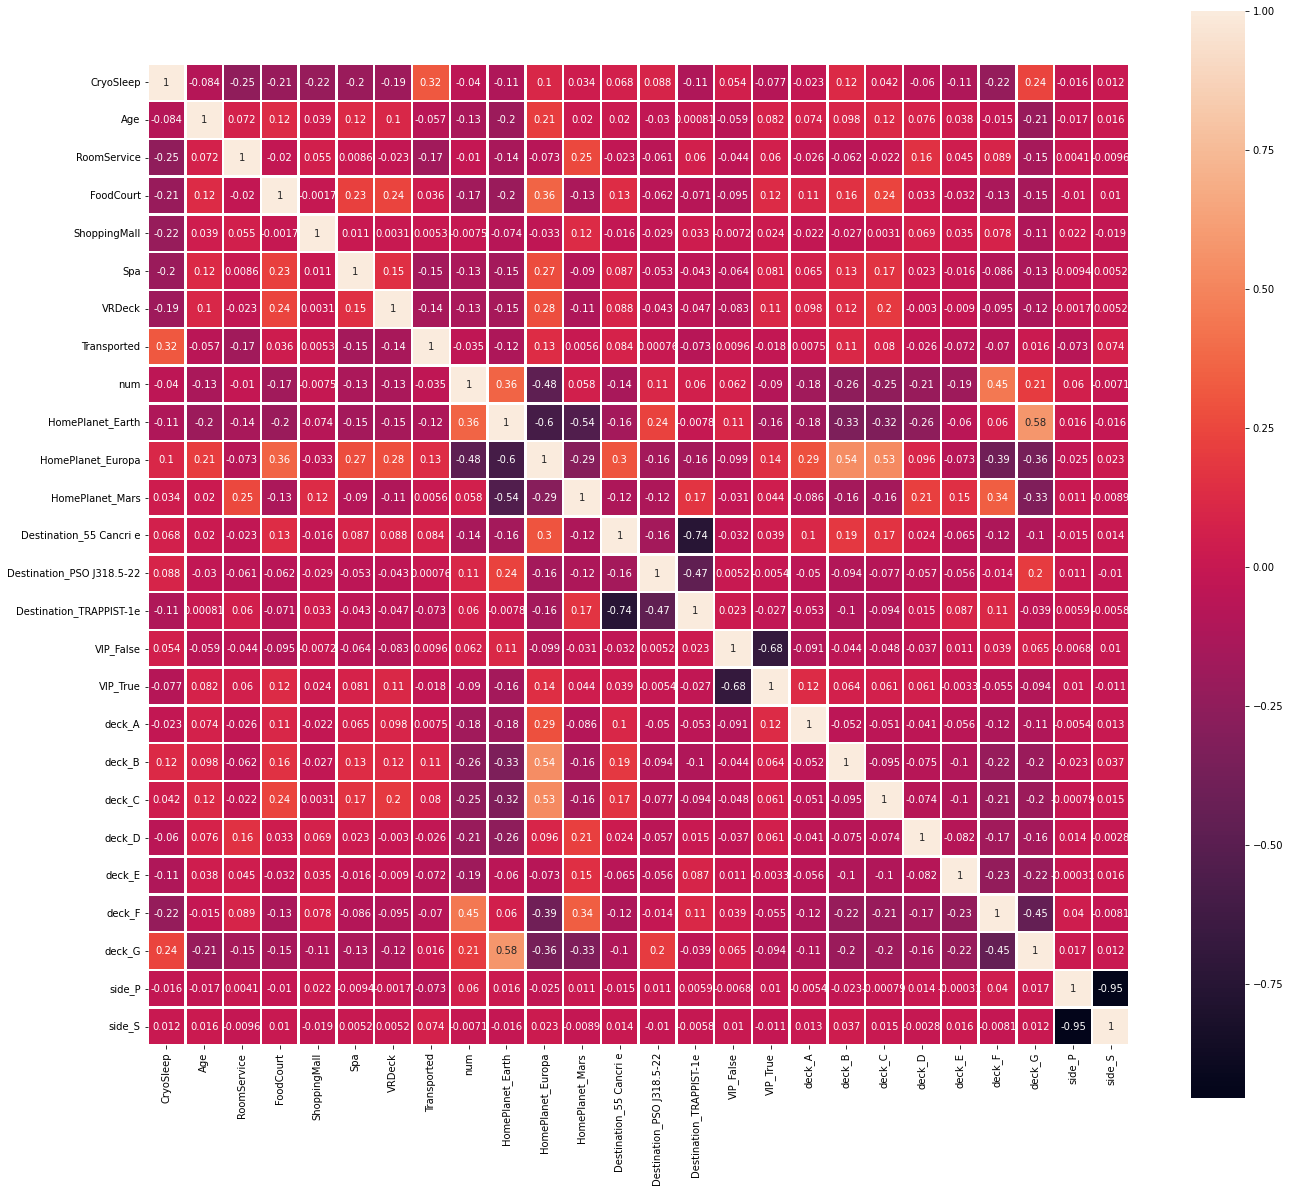

In [ ]:
# Calcular la correlación entre las variables del DataFrame
corr = df.corr()

# Mostrar el mapa de calor de la correlación
plt.figure(figsize=(22, 20))
sns.heatmap(corr,square=True,annot=True,linewidths=1.5)
plt

## Entrenamiento con optimización de hiperparametros:

Lo primero que hacemos es normalizar todo el dataset utilizando la Clase CleanData.

In [ ]:
#@title Normalización de los datos usando la clase CleanData de Preprocessing.py
df = cd.clean(df)

# Se revisa si queda algun valor a nan o null antes de hacer la separación de datos de train y test
null_counts = df.isna().sum()
print(null_counts[null_counts > 0])
df

Series([], dtype: int64)


,cryosleep,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,num,homeplanet_earth,...,vip_true,deck_a,deck_b,deck_c,deck_d,deck_e,deck_f,deck_g,side_p,side_s
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,False,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,...,False,False,True,False,False,False,False,False,True,False
0002_01,False,24.0,109.0,9.0,25.0,549.0,44.0,True,0.0,True,...,False,False,False,False,False,False,True,False,False,True
0003_01,False,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0,False,...,True,True,False,False,False,False,False,False,False,True
0003_02,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0,False,...,False,True,False,False,False,False,False,False,False,True
0004_01,False,16.0,303.0,70.0,151.0,565.0,2.0,True,1.0,True,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,True,34.0,0.0,0.0,0.0,0.0,0.0,False,1496.0,True,...,False,False,False,False,False,False,False,True,False,True
9269_01,False,42.0,0.0,847.0,17.0,10.0,144.0,False,0.0,True,...,False,False,False,False,False,False,False,False,False,False
9271_01,True,0.0,0.0,0.0,0.0,0.0,0.0,False,296.0,False,...,False,False,False,False,True,False,False,False,True,False


In [ ]:
#@title Separar datos entre datos de entrada y etiquetas (resultados)

# Obtenemos la columna transported
df_test = df['transported']

# Eliminamos la columna transported del dataframe
df_train = df.drop('transported',axis=1)

In [ ]:
#@title Separar datos entre entrenamiento y prueba (usando un 75% para entrenamiento y 25% para test)

x_train,x_test,y_train, y_test = train_test_split(df_train,df_test,random_state=1,train_size=0.75)

Esta separación de datos del 75%. Se ha probado con 66%, 80% y 50%. Los resultados son similares pero empeoran aproximadamente un 4%.

In [ ]:
#@title Importamos el modelo DecisionTreeRegressor

modelo_BaseRandomForest = RandomForestClassifier()

In [ ]:
#@title Creamos los hiperparametros e importamos el modelo en el GridSearchCV
parameters = {'criterion' :['gini', 'entropy'],
              'n_estimators': [100,200],
              'max_depth' : [512,1024],
              'min_samples_split':[8, 16],
              'min_samples_leaf': [6, 8],
              'max_features':['sqrt', 'auto'],
              'bootstrap':[True, False],
              'random_state':[1],
              'n_jobs': [-1]
              }
gscv = GridSearchCV(modelo_BaseRandomForest, parameters, cv=5)

Esta selección de hiperparametros es una bastante optimizada despues de hacer varias pruebas. Al principio la predicción tardó unas ~5h.
 

In [ ]:
#@title Entrenamos el modelo RandomForestClassifier utilizando GridSearchCV
start_time = time.time()
gscv.fit(x_train,y_train)
elapsed_time = (time.time() - start_time) / 60
print(f"Elapsed time to compute the training: {elapsed_time:.3f} minutes.")

gscv.best_estimator_

Elapsed time to compute the training: 16.128 minutes.


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=512,
                       max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=8, n_jobs=-1, random_state=1)

In [ ]:
# modelo_DecisionRandomForestOptimizado = RandomForestClassifier(max_depth=512, max_features='sqrt', min_samples_leaf=4, n_jobs=-1)
modelo_DecisionRandomForestOptimizado = gscv.best_estimator_
predict = modelo_DecisionRandomForestOptimizado.predict(x_test)

Ahora vamos a revisar las columnas que han sido tenidas en cuenta para generar los arboles y su importancia. Con esto podemos hacernos una idea de que columnas se pueden volver a eliminar y volver a reentrenar el modelo sin ellas y las columnas que son mas importantes para tomar las decisiones de los arboles.

*Nota: Despues de varias configuraciones se ha detectado que la columna deck_t estaba afectando negativamente a la predicción.*

In [ ]:
#@title Mostrar la importancia de cada atributo en el árbol resultante
for i in range(x_train.columns.shape[0]):
  print(x_train.columns[i],":", modelo_DecisionRandomForestOptimizado.feature_importances_[i])

cryosleep : 0.07475212248922831
age : 0.08528849342093242
roomservice : 0.11334016791763278
foodcourt : 0.09698210203534122
shoppingmall : 0.08065344013282656
spa : 0.15076360360469487
vrdeck : 0.12418368598364901
num : 0.11189148358206277
homeplanet_earth : 0.02302244126175232
homeplanet_europa : 0.021743612365223444
homeplanet_mars : 0.010479846331525324
destination_55 cancri e : 0.007845083037186526
destination_pso j318.5-22 : 0.0029337631523163703
destination_trappist-1e : 0.009986500882634244
vip_false : 0.0017556810689364876
vip_true : 0.0007220159545513818
deck_a : 0.0016394962170997744
deck_b : 0.006884746383077908
deck_c : 0.009562210958365368
deck_d : 0.00273443019101538
deck_e : 0.012804069798252085
deck_f : 0.01220330962493008
deck_g : 0.010109997646937386
side_p : 0.012480283933670925
side_s : 0.015237412026157193


Mostramos el porcentaje de elementos correctamente clasificados y la matrix de confusión.

In [ ]:
#@title Mostrar el porcentaje de elementos correctamente clasificados
print(f"Porcentaje de precisión: {(accuracy_score(y_test, predict) * 100):.2f} %")

Porcentaje de precisión: 74.81 %


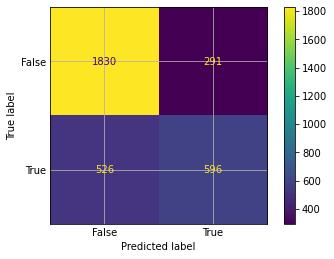

In [ ]:
#@title Representar gráficamente la clasificación obtenida (matriz de confusión)
ConfusionMatrixDisplay.from_predictions(y_test,predict)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

## RE-Entrenamiento con optimización de hiperparametros usando AdaBoost:

Como podemos ver hay un ~74% de precisión con el mejor modelo. Para mejorar esto vamos a usar AdaBoost e intentar ajustar aun mas el algoritmo de RandomForestClassifier:

In [ ]:
parameters = {'algorithm' : ['SAMME', 'SAMME.R'],
              'n_estimators':[50],
              'random_state': [1],
              'learning_rate': [0.3],
              }
modelo_AdaBoostRandomForest = AdaBoostClassifier(base_estimator=modelo_DecisionRandomForestOptimizado)

gscv = GridSearchCV(modelo_AdaBoostRandomForest, parameters)

In [ ]:
#@title Entrenamos el modelo RandomForestClassifier con AdaBoostClassifier utilizando GridSearchCV
start_time = time.time()
gscv.fit(x_train,y_train)
elapsed_time = (time.time() - start_time) / 60
print(f"Elapsed time to compute the training: {elapsed_time:.3f} minutes.")

gscv.best_estimator_

Elapsed time to compute the training: 16.199 minutes.


AdaBoostClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                         criterion='entropy',
                                                         max_depth=512,
                                                         max_features='sqrt',
                                                         min_samples_leaf=8,
                                                         min_samples_split=8,
                                                         n_jobs=-1,
                                                         random_state=1),
                   learning_rate=0.3, random_state=1)

In [ ]:
modelo_DecisionRandomForestOptimizado = gscv.best_estimator_
predict = modelo_DecisionRandomForestOptimizado.predict(x_test)

In [ ]:
#@title Mostrar la importancia de cada atributo en el árbol resultante
for i in range(x_train.columns.shape[0]):
  print(x_train.columns[i],":", modelo_DecisionRandomForestOptimizado.feature_importances_[i])

cryosleep : 0.012824651314879922
age : 0.21498688444650543
roomservice : 0.05238617561769082
foodcourt : 0.05753230184512964
shoppingmall : 0.05302236326174489
spa : 0.05775818273999714
vrdeck : 0.054321263031133285
num : 0.3827677580571283
homeplanet_earth : 0.008795690143346647
homeplanet_europa : 0.006321057692498846
homeplanet_mars : 0.0069456563721856015
destination_55 cancri e : 0.008572597190870793
destination_pso j318.5-22 : 0.004491275213222389
destination_trappist-1e : 0.011811593066431307
vip_false : 0.003374948949818114
vip_true : 0.0010913929775979117
deck_a : 0.0020861057268412755
deck_b : 0.005145909804512947
deck_c : 0.0050083741285871074
deck_d : 0.0032400819711889102
deck_e : 0.006547103527427446
deck_f : 0.009063168046797493
deck_g : 0.007450889085475246
side_p : 0.012280389493464314
side_s : 0.012174186295524098


In [ ]:
#@title Mostrar el porcentaje de elementos correctamente clasificados
print(f"Porcentaje de precisión: {(accuracy_score(y_test, predict) * 100):.2f} %")

Porcentaje de precisión: 72.22 %


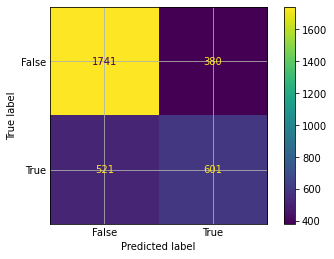

In [ ]:
#@title Representar gráficamente la clasificación obtenida (matriz de confusión)
ConfusionMatrixDisplay.from_predictions(y_test,predict)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

Conclusión del uso de AdaBoostClassifier:

Despues de realizar varias pruebas con diferentes hiperparametros vemos que el AdaBoostClassifier empeora los resultados ya que parece que no se ajusta correctamente al problema que tenemos.

RandomForestClassifier ya se ajusta lo maximo a la prediccion al utilizar el GridSearchCV para la validación cruzada.

## Conclusión final:

En este problema estabamos intentando predecir si un pasajero fue transportado a otra dimensión durante la colisión del Titanic Espacial con la anomalía del espacio-tiempo.

Despues de un analisis de los datos se han decidido separar la columna Cabin en 3 columnas para mejorar la precisión de la predicción al obtener mas parametros significativos. 

Como se puede leer anteriormente se han ido normalizando algunos datos, rellenando y eliminando algunos de los campos que son nulos en el dataset. Estos datos eran "errores de lectura". 

Despues se ha utilizado el Random Forest para hacer una primerra predicción utilizando una validación cruzada con varios parametros.

Estos parametros se han ido puliendo con el tiempo para pasar de una validación de ~5h a unos pocos minutos y alcanzar una precisión del ~74%.

Despues se ha intentado utilizar el AdaBoost para intentar mejorar esa recisión pero como se menciona anteriormente no se ajusta bien a este problema y empeora los resultados aun pasandole diferentes parametros tanto al propio RandomForest como al AdaBoost para indicar la precisión de aprendizaje, estimator, profundidad, etc.

En el primer intento el dataset sin normalizar daba una precisión de un ~50% y se ha conseguido mejorar hasta un 74% lo que es una mejora significativa.